# barrier_reach

Synthesize a probabilistic barrier certificate to get a lower bound on the probability that a target set is reached. 
## Mathematics

Consider the polynomial dynamics

$$
x(t+1) = f(x(t), t, w),  \quad  w \sim \mathcal N(0, \Sigma)
$$
    
and the sets

\begin{align}  
X = \{x : g(x) \geq 0 \} \\
X_0 = \{x : g_0(x) \geq 0\} \\
X_T = \{x : g_T(x) \geq 0\}
\end{align}

We want to find a lower bound on the property that we reach $X_T$ given that we start in $X_0$ and remain in $X$ during the whole transition.

$$
p_{01} = \mathbb{P} \left[ x(T) \in X_T \; \mid \; x(0) \in X_0, x(t) \in X \right]
$$

Consider a certificate $B(x, t)$ satisfying

\begin{align}
    B(x, t) \geq 0        \quad & x \in X  \\
    B(x, 0) \leq \gamma   \quad & x \in X_0     \\
    B(x, T) \geq 1        \quad & x \not \in X_T, x \in X\\
    \mathbb{E} \left[ B(x(t+1), t+1)) \; \mid \; x(t) \right]  \leq B(x(t), t) + c  \quad & x \in X
\end{align}

It obviously follows that with $B(t) = B(x(t), t)$ the last constraint implies $\mathbb{E} \left[ B(T) \right] < B(0) + cT$. Since $B$ is positive we can use Markov's inequality

$$
\mathbb{P} \left[ B(T) \leq 1 \right] = 1 - \mathbb{P} \left[ B(T) \geq 1 \right] \geq 1 - \mathbb{E} [B(T)] \geq 1 - (B(0) + cT)
$$

If $A \impliedby B$ and $C \implies D$, then $\mathbb{P}(A \mid C) \geq \mathbb{P}(B \mid D)$. From the constraints we have that

\begin{align}
    x(T) \in X_T \impliedby B(T) \leq 1, \\
    x(0) \in X_0 \implies B(0) \leq \gamma.
\end{align}

Therefore,
$$
p_{01} = \mathbb{P}\left[x(T) \in X_T \; \mid \; x(0) \in X_0 \right] \geq \mathbb{P}\left[ B(T) \leq 1 \; \mid \; B(0) \leq \gamma \right] \geq 1 - (\gamma + cT).
$$

Thus we search for a barrier certificate that satisfies the conditions above while minimizing $\gamma + cT$.

In [1]:
from sympy.abc import x, y, w
import posipoly as pp

# parameters
n = 2          # dimension
T = 4          # time horizon
sigma = 0.1    # noise standard deviation
tot_deg = 6    # overall degree of ppp

# polynomials defining sets
g  = pp.Polynomial.from_sympy(1, [x,y])
g0 = pp.Polynomial.from_sympy(0.25**2 - x**2 - y**2, [x,y])
gT = pp.Polynomial.from_sympy(0.5**2 - (x-1)**2 - y**2, [x,y])

# dynamics: 
#  x(t+1) = x(t) + 0.25 + w
#  y(t+1) = y(t)
ft_x = pp.Polynomial.from_sympy(x + 0.25 + w, [x,y,w])
ft_y = pp.Polynomial.from_sympy(y, [x,y,w])

We synhesize a separate barrier for each discrete time step, i.e. $B(x,t) = B_t(x)$. Using the S procedure we can rewrite the problem above as

\begin{align}
    c + B_t(x) - \mathbb{E} [B_{t+1}(f(x, t, w)) ] - \sigma_1^t(x) g(x)   \geq 0, & \qquad  t=0, ..., T-1 \\
    \gamma - B_0(x) - \sigma_2(x) g_0(x)  \geq 0, & \\
    B_T(x) - 1 + \sigma_{3a}(x) g_1(x) - \sigma_{3b}g(x)      \geq 0, & \\
    B_t(x) - \sigma_4^t(x) g(x)              \geq 0, & \qquad  t=0, ..., T \\
    \sigma_1^t(x) \geq 0,    & \qquad  t=0, ..., T-1 \\
    \sigma_4^t(x) \geq 0,    & \qquad  t=0, ..., T \\
    \sigma_2(x), \sigma_{3a}(x), \sigma_{3b}(x) \geq 0, \\
\end{align}

In [2]:
deg_B = tot_deg   # need to subtract if deg f larger than 1
deg_g0 = tot_deg-g0.d
deg_gT = tot_deg-gT.d
deg_g = tot_deg-g.d

prog = pp.PPP()

prog.add_var('c', n, 0, 'coef')      # scalar variable = polynomial of degree 0
prog.add_var('gamma', n, 0, 'coef')  # scalar variable

for t in range(T+1):
    prog.add_var('B{}'.format(t), n, deg_B, 'coef')

for t in range(T):
    prog.add_var('s1{}'.format(t), n, deg_g, 'pp')

prog.add_var('s2', n, deg_g0, 'pp')
prog.add_var('s3a', n, deg_gT, 'pp')
prog.add_var('s3b', n, deg_g, 'pp')

for t in range(T+1):
    prog.add_var('s4{}'.format(t), n, deg_g, 'pp')

Prepare the transformations

In [3]:
# Identity for scalars to tot_deg
T1 = pp.PTrans.eye(n0=n, d0=0, n1=n, d1=tot_deg)

# Identity for scalars to scalar
T10 = pp.PTrans.eye(n0=n, d0=0, n1=n, d1=0)

# B(x,y) -> E_w[ B(fx(x,y,w), fy(x,y,w)) ]
TBp = pp.PTrans.gaussian_expectation(n0=3, d0=deg_B, i=2, sigma=sigma) \
      * pp.PTrans.composition(n0=n, d0=deg_B, g_list=[ft_x, ft_y])

# Identity for B
TB  = pp.PTrans.eye(n, deg_B)     

# Multiplication with g, g0, g1
Tg  = pp.PTrans.mul_pol(n, deg_g, g)
Tg0 = pp.PTrans.mul_pol(n, deg_g0, g0)
TgT = pp.PTrans.mul_pol(n, deg_gT, gT)

# Identity for free variables
Tfr = pp.PTrans.eye(n, tot_deg)

These are the constraints in algebra form

    T1.c + TB.Bt - Tbp.B(t+1) - Tg.s1t pp   t=0, ..., T-1    (1)
    T1.gamma - TB.B0 - Tg0.s2          pp                    (2)
    TB.BT + TgT.s3a - Tg.s3b - 1       pp                    (3)
    TB.Bt - Tg.s4t                     pp   t=0, ..., T      (4)

In [4]:
# add (1)
for t in range(T):
    Aop = {'c': T1,
           'B{}'.format(t): TB, 
           'B{}'.format(t+1): -TBp,
           's1{}'.format(t): -Tg}
    prog.add_constraint(Aop, pp.Polynomial.zero(n), 'pp')

# add (2)
prog.add_constraint({'gamma': T1, 'B0': -TB, 's2': -Tg0}, pp.Polynomial.zero(n), 'pp')
    
# add (3)
prog.add_constraint({'B{}'.format(T): TB, 's3a': TgT, 's3b': -Tg}, pp.Polynomial.one(n), 'pp')

# add (4)
for t in range(T+1):
    Aop = {'B{}'.format(t): TB, 
           's4{}'.format(t): -Tg}
    prog.add_constraint(Aop, pp.Polynomial.zero(n), 'pp')
    
# add inequality: gamma <= 1  (to exclude large solutions)
prog.add_constraint({'gamma': T10}, pp.Polynomial.one(n), 'iq')

# set c=0
# prog.add_row({'c': T10}, pp.Polynomial.zero(n), 'eq')

# add objective
prog.set_objective({'c': pp.PTrans.eval0(n, 0)* T, 'gamma': pp.PTrans.eval0(n, 0)})

Time to solve it!

In [5]:
sol, status = prog.solve('psd')

c = prog.get_poly('c')(0,0)
gamma = prog.get_poly('gamma')(0,0)

lb = 1-(gamma+c*T)

print('got c={:.2f} and gamma={:.2f}'.format(c, gamma))
print('lower bound is {:.2f}'.format(lb))

import scipy.stats
import numpy as np
print("real probablity ~ {:.2f}".format(scipy.stats.norm.cdf(0.25/np.sqrt(4*sigma**2))))

optimizing...
solved in 0.31s
solsta.optimal
got c=-0.14 and gamma=0.95
lower bound is 0.62
real probablity ~ 0.89


From the certificates we can now plot a lower bound on the probability that the target set is reached. From the proof above it follows that

$$
\mathbb{P}(x(T) \in X_1 \mid x(t) = x) \geq 1 - (c(T-t) + B_t(x)).
$$

<IPython.core.display.Javascript object>


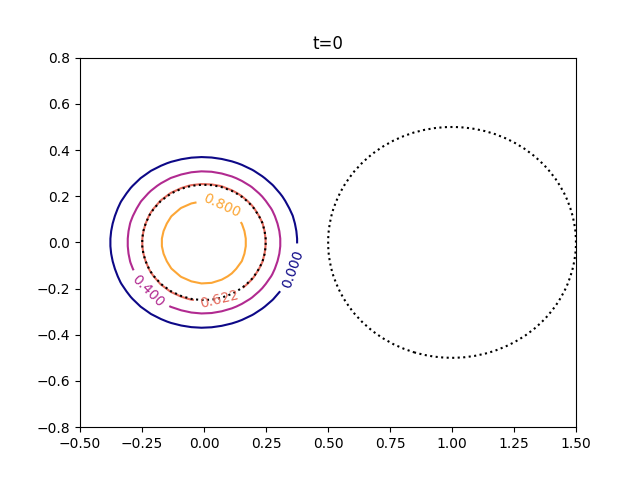

<IPython.core.display.Javascript object>


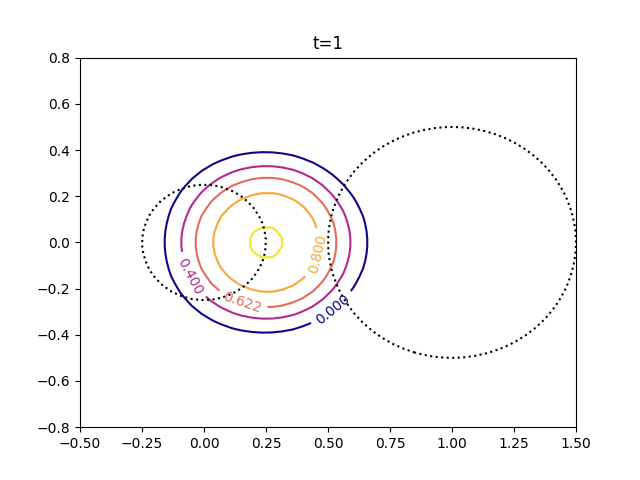

<IPython.core.display.Javascript object>


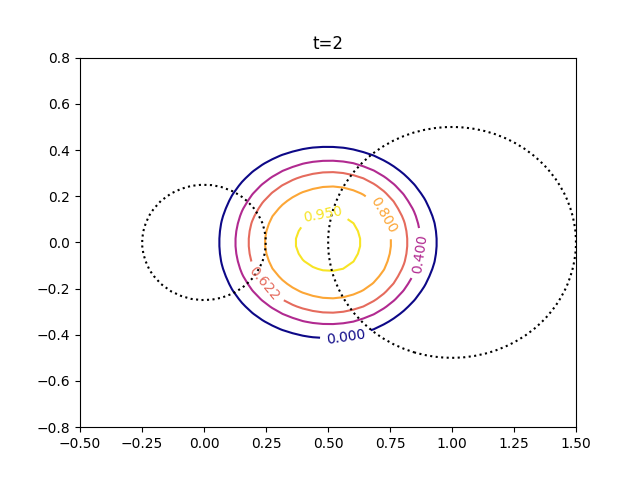

<IPython.core.display.Javascript object>


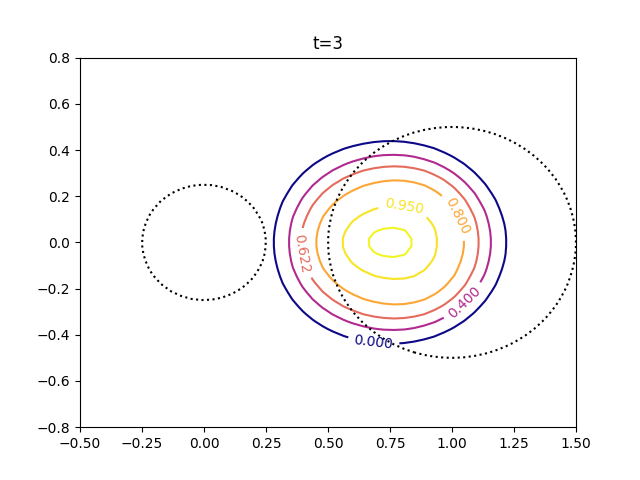

<IPython.core.display.Javascript object>


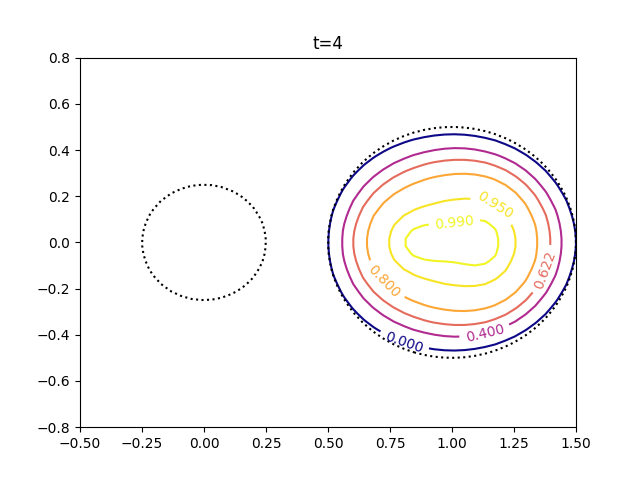

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

xx = np.linspace(-0.5, 1.5, 50)
yy = np.linspace(-0.8, 0.8, 50)

XX, YY = np.meshgrid(xx, yy)

g0_val = np.vectorize(g0)(XX, YY)
gT_val = np.vectorize(gT)(XX, YY)

levels = sorted([0, 0.4, 0.8, 0.95, 0.99, lb])

for t in [0, 1, 2, 3, 4]:
    Bt = prog.get_poly('B{}'.format(t))
    proba_min = 1 - (np.vectorize(Bt)(XX, YY) + c * (T-t))
    plt.figure()
    CS = plt.contour(XX, YY, proba_min, levels=levels, cmap=cm.get_cmap('plasma'), vmin=0, vmax=1)
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.contour(XX, YY, g0_val, levels=[0], colors='black', linestyles='dotted')
    plt.contour(XX, YY, gT_val, levels=[0], colors='black', linestyles='dotted')
    plt.title('t={}'.format(t))

plt.show()